# PLANIFICACIÓN

## - Generación de diagrama de Gantt con la planificación temporal



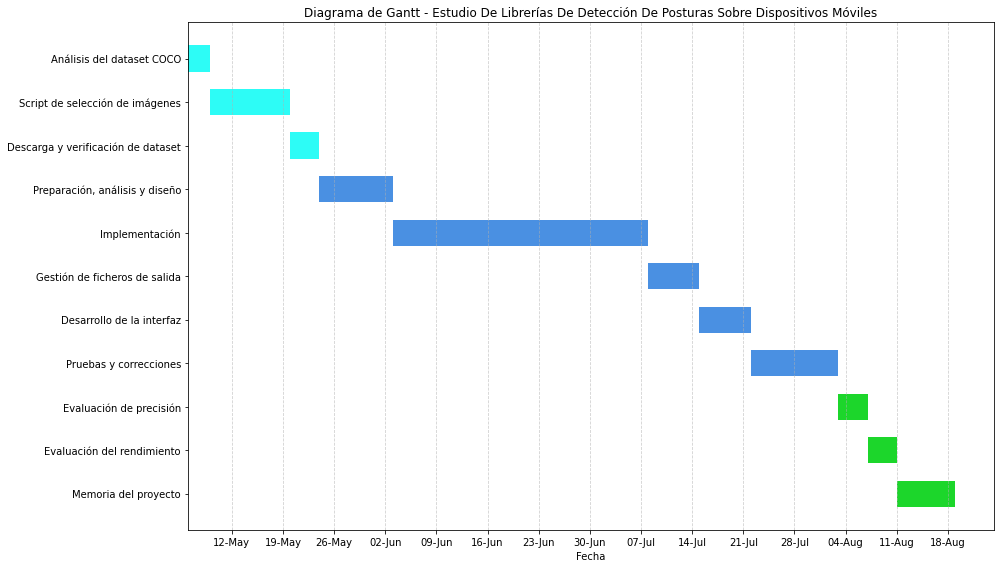

In [1]:

####################################################################################################
# Generación de diagrama de Gantt para la fase de planificación
####################################################################################################

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# Definimos el color de la fase 1
colorCian = "#2dfcf6"
# Definimos el color de la fase 2
colorAzul = "#4a90e2"
# Definimos el color de la fase 3
colorVerde = "#1cd62b"

# Definimos las fases completas del proyecto con descripción, fecha de inicio, duración en días y color en que se mostrarán
infoFases = [
    # FASE 1 – Preparación del dataset
    ("Análisis del dataset COCO", "06-05-2025", 3, colorCian),
    ("Script de selección de imágenes", "09-05-2025", 11, colorCian),
    ("Descarga y verificación de dataset", "20-05-2025", 4, colorCian),

    # FASE 2 – Desarrollo de la app
    ("Preparación, análisis y diseño", "24-05-2025", 10, colorAzul),
    ("Implementación", "03-06-2025", 35, colorAzul),
    ("Gestión de ficheros de salida", "08-07-2025", 7, colorAzul),
    ("Desarrollo de la interfaz", "15-07-2025", 7, colorAzul),
    ("Pruebas y correcciones", "22-07-2025", 12, colorAzul),

    # FASE 3 – Evaluación y análisis
    ("Evaluación de precisión", "03-08-2025", 4, colorVerde),
    ("Evaluación del rendimiento", "07-08-2025", 4, colorVerde),
    ("Memoria del proyecto", "11-08-2025", 8, colorVerde)
]

# Leemos la información de las subfases de cada fase en variables
nombreFase = [faseTemp[0] for faseTemp in infoFases]
fechaIniFase = [datetime.strptime(faseTemp[1], "%d-%m-%Y") for faseTemp in infoFases]
duracionFase = [faseTemp[2] for faseTemp in infoFases]
colorFase = [faseTemp[3] for faseTemp in infoFases]

# Creamos el gráfico Gantt
fig, ax = plt.subplots(figsize=(14, 8))

for i, (fechaIniTemp, duracionTemp, colorTemp) in enumerate(zip(fechaIniFase, duracionFase, colorFase)):
    ax.barh(i, duracionTemp, left=fechaIniTemp, height=0.6, color=colorTemp)

# Añadimos las fechas en eje X
ax.xaxis_date()
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%b"))

# Añadimos las subfases en eje Y
ax.set_yticks(range(len(infoFases)))
ax.set_yticklabels(nombreFase)
ax.invert_yaxis()
ax.set_title("Diagrama de Gantt - Estudio De Librerías De Detección De Posturas Sobre Dispositivos Móviles")
ax.set_xlabel("Fecha")
ax.grid(True, which='both', axis='x', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


# FASE 1: obtención de dataset de imágenes y modelos Yolo

## - Descarga de las imágenes que formarán el dataset de pruebas de la APP. Se descargarán las imágenes que contienen una sola persona y un número mínimo de 15 keypoints para esa persona.

## - Conversión de modelos Yolo8-pose a formato TensorFlow Lite para su utilización en la APP de pruebas.



In [2]:

####################################################################################################
# Descarga de las imágenes que formarán el dataset de pruebas de la APP. 
# Se descargarán las imágenes que contienen una sola persona y un número mínimo de 15 keypoints 
# para esa persona.
####################################################################################################

%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt

import requests
from pathlib import Path


print('\n')
print('--------------------------------------------------')
print('Iniciado procesado del dataset')
print('--------------------------------------------------')

# Definimos el mínimo de keypoints visibles por el que filtraremos las imágenes
MIN_KEYPOINTS = 15

# Cargamos la información de los keypoints de las personas
personKeypointsVal2017File = './annotations_train-val/person_keypoints_val2017.json'
personKeypointsVal2017COCO = COCO(personKeypointsVal2017File)

# Obtenemos el identificador de la categoria de personas
personCategoryId = personKeypointsVal2017COCO.getCatIds(catNms=['person'])

# Obtenemos los identificadores de las imágenes en la categoria de personas
personCategoryImagesIds = personKeypointsVal2017COCO.getImgIds(catIds=personCategoryId)

# Obtenemos las anotaciones (contienen los keypoints) de las imágenes de personas
personCategoryAnnotationIds = personKeypointsVal2017COCO.getAnnIds(imgIds=personCategoryImagesIds, catIds=personCategoryId, iscrowd=None)  # iscrowd == 0
personCategoryAnnotations = personKeypointsVal2017COCO.loadAnns(personCategoryAnnotationIds)

# Array para almacenar los identificadores de las imágenes temporalmente
imageIdsTemp = []
# Array para almacenar los identificadores de las imágenes únicas
singlePersonImageIds = []
# Array para almacenar los elementos con anotaciones duplicadas
multiPersonImageIds = []
# Filtramos la lista para quedarnos con las imágenes que solo tienen una anotación (tienen sólo una persona en la imagen)
for annotationTemp in personCategoryAnnotations:
    # Metemos el id de cada imagen con alguna anotación en imageIdsTemp
    if annotationTemp['image_id'] not in imageIdsTemp:
        imageIdsTemp.append(annotationTemp['image_id'])
    else:
        # Metemos el id de cada imagen con mas de una anotación en multiPersonImageIds (sólo una vez)
        if annotationTemp['image_id'] not in multiPersonImageIds:
            multiPersonImageIds.append(annotationTemp['image_id'])

# Nos quedamos con los ids de las imágenes únicas que no tienen ningun id duplicado (anotación duplicada)
for idImageTemp in imageIdsTemp:
    if idImageTemp not in multiPersonImageIds:
        singlePersonImageIds.append(idImageTemp)


# Cargamos las anotaciones de esas imágenes con una anotación unica (tienen sólo una persona en la imagen)
singlePersonAnnotationIds = personKeypointsVal2017COCO.getAnnIds(imgIds=singlePersonImageIds, catIds=personCategoryId, iscrowd=None)
singlePersonAnnotations = personKeypointsVal2017COCO.loadAnns(singlePersonAnnotationIds)

# Array para almacenar los identificadores de las imágenes con una sola persona
singlePersonAnnotationFilteredIds = []

# Filtramos las imágenes que tienen al menos 1 keypoint en su anotacion
# - crear una lista de identificadores de las imágenes a descargar
# - crear una lista con las lineas con la información de keypoints de cada imagen para el fichero de validación
for annotationTemp in singlePersonAnnotations:
    if annotationTemp['num_keypoints'] >= MIN_KEYPOINTS:                                    # 316 imágenes con 15 o más puntos
    
        # Identificador de la imagen
        imageIdTemp = annotationTemp['image_id']

        # Añadimos el identificador de la imagen que vamos a descargar al array de identificadores filtrados
        singlePersonAnnotationFilteredIds.append(imageIdTemp)                                               
    
    
# Impresión de datos para seguimiento
print('\n')
print('--------------------------------------------------')
print('Id de la categoría "person": ', personCategoryId)
print('Número de imágenes pertenecientes a la categoría "person": ', len(personCategoryImagesIds))
print('Anotaciones totales para las imágenes de la categoría "person" (por número total de ids): ', len(personCategoryAnnotationIds))
print('Anotaciones totales para las imágenes de la categoría "person" (cargadas del fichero json): ', len(personCategoryAnnotations))
print('Número de imágenes con una sola persona: ', len(singlePersonImageIds))
print('Número de imágenes con una sola persona filtradas (tienen 15 o más keypoints): ', len(singlePersonAnnotationFilteredIds))
print('--------------------------------------------------')


# Creamos la carpeta para el dataset
Path('./Dataset').mkdir(parents=True, exist_ok=True)
# Creamos la carpeta para las imágenes del dataset
Path('./Dataset/Images').mkdir(parents=True, exist_ok=True)


# Descarga de imágenes del dataset
print('\n')
print('Descargando imágenes del dataset...')

# Variable para almacenar los nombres de las imágenes descargadas
imageFileNamesLines = []

# Descargamos en local las imágenes filtradas (aquellas que tienen una sola persona con al menos un keypoint en sus anotaciones)
imagesTemp = personKeypointsVal2017COCO.loadImgs(singlePersonAnnotationFilteredIds)
for imageTemp in imagesTemp:
    img_data = requests.get(imageTemp['coco_url']).content
    with open('./Dataset/Images/' + imageTemp['file_name'], 'wb') as imageFileTemp:
        imageFileTemp.write(img_data)
        
        imageFileNamesLines.append(imageTemp['file_name'])

        
# Creamos el fichero de control con los nombres de las imágenes descargadas
with open("./Dataset/Images/imageFileNames.txt", "wt") as imageNamesFile:
    for imageNamesFileLineTemp in imageFileNamesLines:
        # Escribimos el nombre de la imagen en el fichero de listado de imágenes del dataset
        imageNamesFile.write(imageNamesFileLineTemp)
        # Escribimos un retorno se linea
        imageNamesFile.write('\n')

print('Descargando imágenes del dataset...Finalizado')


print('\n')
print('--------------------------------------------------')
print('Finalizado procesado del dataset')
print('--------------------------------------------------')





--------------------------------------------------
Iniciado procesado del dataset
--------------------------------------------------
loading annotations into memory...
Done (t=0.33s)
creating index...
index created!


--------------------------------------------------
Id de la categoría "person":  [1]
Número de imágenes pertenecientes a la categoría "person":  2693
Anotaciones totales para las imágenes de la categoría "person" (por número total de ids):  11004
Anotaciones totales para las imágenes de la categoría "person" (cargadas del fichero json):  11004
Número de imágenes con una sola persona:  1045
Número de imágenes con una sola persona filtradas (tienen 15 o más keypoints):  316
--------------------------------------------------


Descargando imágenes del dataset...
Descargando imágenes del dataset...Finalizado


--------------------------------------------------
Finalizado procesado del dataset
--------------------------------------------------


In [3]:

####################################################################################################
# Exportación de modelos Yolo8-pose a formato TensorFlow Lite lite para su utilización en la APP de pruebas.
# 
# Parámetros de exportación:
# format="tflite"   formato de salida tensorflow lite
# imgsz=320         tamaño de las imágenes que tratará el modelo
# max_det=1         limitamos el número máximo de detecciones por imagen (estamos trabajando con imagenes de una sola persona)
# nms=True          supresión no máxima (NMS) activada (mejora la eficacia del postprocesamiento de detección)
####################################################################################################

from ultralytics import YOLO


print('\n')
print('--------------------------------------------------')
print('Iniciado exportación de modelos Yolo8-pose')
print('--------------------------------------------------')

# Cargamos y exportamos el modelo Yolo8 nano
model = YOLO("./Modelos_YOLO8/yolov8n-pose.pt")
model.export(format="tflite", imgsz=320, max_det=1, nms=True)

# Cargamos y exportamos el modelo Yolo8 small
model = YOLO("./Modelos_YOLO8/yolov8s-pose.pt")
model.export(format="tflite", imgsz=320, max_det=1, nms=True)

# Cargamos y exportamos el modelo Yolo8 medium
model = YOLO("./Modelos_YOLO8/yolov8m-pose.pt")
model.export(format="tflite", imgsz=320, max_det=1, nms=True)

print('\n')
print('--------------------------------------------------')
print('Finalizada la exportación de modelos Yolo8-pose')
print('--------------------------------------------------')




--------------------------------------------------
Iniciado exportación de modelos Yolo8-pose
--------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████| 6.52M/6.52M [00:00<00:00, 24.5MB/s]


Ultralytics 8.3.152  Python-3.9.7 torch-2.7.1+cpu CPU (Intel Core(TM) i7-6700 3.40GHz)
YOLOv8n-pose summary (fused): 81 layers, 3,289,964 parameters, 0 gradients, 9.2 GFLOPs

PyTorch: starting from 'Modelos_YOLO8\yolov8n-pose.pt' with input shape (1, 3, 320, 320) BCHW and output shape(s) (1, 1, 57) (6.5 MB)
requirements: Ultralytics requirements ['tf_keras', 'ai-edge-litert>=1.2.0', 'onnx2tf>=1.26.3', 'protobuf>=5'] not found, attempting AutoUpdate...
WARNING Retry 1/2 failed: Command 'pip install --no-cache-dir "tf_keras" "ai-edge-litert>=1.2.0" "onnx2tf>=1.26.3" "protobuf>=5" --extra-index-url https://pypi.ngc.nvidia.com' returned non-zero exit status 1.
WARNING Retry 2/2 failed: Command 'pip install --no-cache-dir "tf_keras" "ai-edge-litert>=1.2.0" "onnx2tf>=1.26.3" "protobuf>=5" --extra-index-url https://pypi.ngc.nvidia.com' returned non-zero exit status 1.
WARNING requirements:  Command 'pip install --no-cache-dir "tf_keras" "ai-edge-litert>=1.2.0" "onnx2tf>=1.26.3" "protobuf>=5" 

100%|█████████████████████████████████████████████████████████████████████████████| 1.11M/1.11M [00:00<00:00, 20.3MB/s]
Unzipping calibration_image_sample_data_20x128x128x3_float32.npy.zip to C:\Users\admin\MASTER\calibration_image_sample_



ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.57...
ONNX: export success  3.3s, saved as 'Modelos_YOLO8\yolov8n-pose.onnx' (12.7 MB)
TensorFlow SavedModel: starting TFLite export with onnx2tf 1.20.0...
TensorFlow SavedModel: export success  95.5s, saved as 'Modelos_YOLO8\yolov8n-pose_saved_model' (34.0 MB)

TensorFlow Lite: starting export with tensorflow 2.12.0...
TensorFlow Lite: export success  0.0s, saved as 'Modelos_YOLO8\yolov8n-pose_saved_model\yolov8n-pose_float32.tflite' (12.8 MB)

Export complete (106.1s)
Results saved to C:\Users\admin\MASTER\Modelos_YOLO8
Predict:         yolo predict task=pose model=Modelos_YOLO8\yolov8n-pose_saved_model\yolov8n-pose_float32.tflite imgsz=320  
Validate:        yolo val task=pose model=Modelos_YOLO8\yolov8n-pose_saved_model\yolov8n-pose_float32.tflite imgsz=320 data=/usr/src/app/ultralytics/datasets/coco-pose.yaml  
Visualize:       https://netron.app


100%|█████████████████████████████████████████████████████████████████████████████| 22.4M/22.4M [00:01<00:00, 18.9MB/s]


Ultralytics 8.3.152  Python-3.9.7 torch-2.7.1+cpu CPU (Intel Core(TM) i7-6700 3.40GHz)
YOLOv8s-pose summary (fused): 81 layers, 11,615,724 parameters, 0 gradients, 30.2 GFLOPs

PyTorch: starting from 'Modelos_YOLO8\yolov8s-pose.pt' with input shape (1, 3, 320, 320) BCHW and output shape(s) (1, 1, 57) (22.4 MB)
requirements: Ultralytics requirements ['tf_keras', 'ai-edge-litert>=1.2.0', 'onnx2tf>=1.26.3', 'protobuf>=5'] not found, attempting AutoUpdate...
WARNING Retry 1/2 failed: Command 'pip install --no-cache-dir "tf_keras" "ai-edge-litert>=1.2.0" "onnx2tf>=1.26.3" "protobuf>=5" --extra-index-url https://pypi.ngc.nvidia.com' returned non-zero exit status 1.
WARNING Retry 2/2 failed: Command 'pip install --no-cache-dir "tf_keras" "ai-edge-litert>=1.2.0" "onnx2tf>=1.26.3" "protobuf>=5" --extra-index-url https://pypi.ngc.nvidia.com' returned non-zero exit status 1.
WARNING requirements:  Command 'pip install --no-cache-dir "tf_keras" "ai-edge-litert>=1.2.0" "onnx2tf>=1.26.3" "protobuf>=

100%|█████████████████████████████████████████████████████████████████████████████| 50.8M/50.8M [00:02<00:00, 24.4MB/s]


Ultralytics 8.3.152  Python-3.9.7 torch-2.7.1+cpu CPU (Intel Core(TM) i7-6700 3.40GHz)
YOLOv8m-pose summary (fused): 101 layers, 26,447,596 parameters, 0 gradients, 81.0 GFLOPs

PyTorch: starting from 'Modelos_YOLO8\yolov8m-pose.pt' with input shape (1, 3, 320, 320) BCHW and output shape(s) (1, 1, 57) (50.8 MB)
requirements: Ultralytics requirements ['tf_keras', 'ai-edge-litert>=1.2.0', 'onnx2tf>=1.26.3', 'protobuf>=5'] not found, attempting AutoUpdate...
WARNING Retry 1/2 failed: Command 'pip install --no-cache-dir "tf_keras" "ai-edge-litert>=1.2.0" "onnx2tf>=1.26.3" "protobuf>=5" --extra-index-url https://pypi.ngc.nvidia.com' returned non-zero exit status 1.
WARNING Retry 2/2 failed: Command 'pip install --no-cache-dir "tf_keras" "ai-edge-litert>=1.2.0" "onnx2tf>=1.26.3" "protobuf>=5" --extra-index-url https://pypi.ngc.nvidia.com' returned non-zero exit status 1.
WARNING requirements:  Command 'pip install --no-cache-dir "tf_keras" "ai-edge-litert>=1.2.0" "onnx2tf>=1.26.3" "protobuf>

# FASE 3: Análisis de resultados

## - Análisis de la precisión de los modelos

## - Ejemplos visuales de estimaciones


In [4]:

####################################################################################################
# Obtención de identificadores de imágenes consideradas MAS ADECUADAS para la estimación de poses
####################################################################################################

from pycocotools.coco import COCO
import numpy as np
from collections import defaultdict

# Cargamos las anotaciones de validación de COCO
annotationFile = './annotations_train-val/person_keypoints_val2017.json'
cocoGt = COCO(annotationFile)

# Obtenemos el identificador de la categoria de personas
personCategoryId = cocoGt.getCatIds(catNms=['person'])

# Obtenemos los identificadores de las imágenes en la categoria de personas
personCategoryImagesIds = cocoGt.getImgIds(catIds=personCategoryId)

# Obtenemos las anotaciones (contienen los keypoints) de las imágenes de personas
personCategoryAnnotationIds = cocoGt.getAnnIds(imgIds=personCategoryImagesIds, catIds=personCategoryId, iscrowd=None)
personCategoryAnnotations = cocoGt.loadAnns(personCategoryAnnotationIds)

# Agrupamos las anotaciones por imagen
annotationsByImage = defaultdict(list)
for annotationTemp in personCategoryAnnotations:
    annotationsByImage[annotationTemp['image_id']].append(annotationTemp)

# Definimos un array para almacenar los identificadores de las imágenes adecuadas
idImagesAppropriate = []

# Definimos el número mínimo de keypoints de la persona en la imagen
MIN_KEYPOINTS = 15

# Definimos la tolerancia para centrado (proporción de distancia máxima del centro)
CENTER_TOLERANCE = 0.15             # Consideraremos "centrada" si > 15% (offset desde el centro de la imagen)

# Definimos los umbrales de tamaño relativo (bbox respecto a imagen)
MIN_WIDTH_RATIO = 0.25
MIN_HEIGHT_RATIO = 0.75

# Definimos una variable de control con el número de imágenes procesadas (para comprobar que es el mismo dataset general)
totalImagesNumber = 0


# Recorremos cada imagen que contiene una persona
for imageId, personAnnotations in annotationsByImage.items():
    # Si tiene más de una anotación de personas la descartamos
    if len(personAnnotations) != 1:
        continue

    # Si tiene menos del mínimo de keypoints definidos la descartamos
    annotationTemp = personAnnotations[0]
    if 'keypoints' not in annotationTemp or annotationTemp['num_keypoints'] < MIN_KEYPOINTS:
        continue

    # Contamos el núnermo de imágenes del dataset que estamos procesando (deberian ser las 316 del dataset general)
    totalImagesNumber = totalImagesNumber + 1

    # Obtenemos los datos de la imágen y de la persona en la imagen (coordenadas de la caja)
    imageInfoTemp = cocoGt.loadImgs(imageId)[0]
    imageWidth = imageInfoTemp['width']
    imageHeight = imageInfoTemp['height']
    x, y, w, h = annotationTemp['bbox']

    # Calculamos el tamaño relativo de la bounding box
    rel_w = w / imageWidth
    rel_h = h / imageHeight

    # Si el tamaño relativo de la bounding box está fuera de los márgenes definidos la descartamos
    if rel_w < MIN_WIDTH_RATIO or rel_h < MIN_HEIGHT_RATIO:
        continue

    # Calculamos su posición con respecto al centro de la imagen
    boxCenterX = x + w / 2
    boxCenterY = y + h / 2
    imageCenterX = imageWidth / 2
    imageCenterY = imageHeight / 2
    
    offset_x = abs(boxCenterX - imageCenterX) / imageWidth
    offset_y = abs(boxCenterY - imageCenterY) / imageHeight

    # Si el tamaño relativo de la bounding box está fuera de los márgenes definidos la descartamos
    if max(offset_x, offset_y) > CENTER_TOLERANCE:
        continue

    # Si pasa todos los filtros, almacenamos los identificadores en una variable para su uso posterior
    idImagesAppropriate.append(imageId)


# Mostramos los resultados
print('--------------------------------------------------')
print('IMAGENES ADECUADAS PARA IDENTIFICACION DE POSES')
print('--------------------------------------------------')
print("Total imágenes procesadas: ", totalImagesNumber)
print("Total imágenes con 1 persona CENTRADA y CERCANA:", len(idImagesAppropriate))
print("Lista de identificadores de las imágenes:", idImagesAppropriate)


loading annotations into memory...
Done (t=0.34s)
creating index...
index created!
--------------------------------------------------
IMAGENES ADECUADAS PARA IDENTIFICACION DE POSES
--------------------------------------------------
Total imágenes procesadas:  316
Total imágenes con 1 persona CENTRADA y CERCANA: 65
Lista de identificadores de las imágenes: [401446, 270474, 188592, 65736, 295138, 295478, 785, 172877, 328601, 42102, 337055, 67180, 444142, 493442, 239537, 199055, 551439, 125472, 166478, 223959, 109313, 3156, 388215, 281929, 273760, 445792, 52591, 257624, 454404, 560911, 61747, 463174, 102820, 168974, 382009, 365642, 439522, 513524, 480936, 546717, 22479, 161781, 481386, 22705, 473406, 80273, 547336, 72281, 154425, 203639, 64462, 474095, 89078, 97278, 187585, 64718, 32081, 343453, 351823, 368212, 409198, 171788, 401244, 327601, 327617]


In [5]:

####################################################################################################
# Obtención de identificadores de imágenes consideradas NO ADECUADAS para la estimación de poses
####################################################################################################

from pycocotools.coco import COCO
import numpy as np
from collections import defaultdict

# Cargamos las anotaciones de validación de COCO
annotationFile = './annotations_train-val/person_keypoints_val2017.json'
cocoGt = COCO(annotationFile)

# Obtenemos el identificador de la categoria de personas
personCategoryId = cocoGt.getCatIds(catNms=['person'])

# Obtenemos los identificadores de las imágenes en la categoria de personas
personCategoryImagesIds = cocoGt.getImgIds(catIds=personCategoryId)

# Obtenemos las anotaciones (contienen los keypoints) de las imágenes de personas
personCategoryAnnotationIds = cocoGt.getAnnIds(imgIds=personCategoryImagesIds, catIds=personCategoryId, iscrowd=None)
personCategoryAnnotations = cocoGt.loadAnns(personCategoryAnnotationIds)

# Agrupamos las anotaciones por imagen
annotationsByImage = defaultdict(list)
for annotationTemp in personCategoryAnnotations:
    annotationsByImage[annotationTemp['image_id']].append(annotationTemp)

# Definimos un array para almacenar los identificadores de las imágenes NO adecuadas
idImagesInappropriate = []

# Definimos el número mínimo de keypoints de la persona en la imagen
MIN_KEYPOINTS = 15

# Definimos la tolerancia para centrado (proporción de distancia máxima del centro)
MIN_CENTER_OFFSET = 0.25        # Consideraremos "no centrada" si > 25% (offset desde el centro de la imagen)

# Definimos el umbrales de tamaño relativo (bbox respecto a imagen)
MAX_SIZE_RATIO = 0.25           # Consideraremos "lejana" si < 25% (el bbox debe ocupar al menos 25% del ancho o alto)

# Definimos una variable de control con el número de imágenes procesadas (para comprobar que es el mismo dataset general)
totalImagesNumber = 0


# Recorremos cada imagen que contiene una persona
for imageId, personAnnotations in annotationsByImage.items():
    # Si tiene más de una anotación de personas la descartamos
    if len(personAnnotations) != 1:
        continue

    # Si tiene menos del mínimo de keypoints definidos la descartamos
    annotationTemp = personAnnotations[0]
    if 'keypoints' not in annotationTemp or annotationTemp['num_keypoints'] < MIN_KEYPOINTS:
        continue

    # Contamos el núnermo de imágenes del dataset que estamos procesando (deberian ser las 316 del dataset general)
    totalImagesNumber = totalImagesNumber + 1
        
    # Obtenemos los datos de la imágen y de la persona en la imágen (coordenadas de la caja)
    imageInfoTemp = cocoGt.loadImgs(imageId)[0]
    imageWidth = imageInfoTemp['width']
    imageHeight = imageInfoTemp['height']
    x, y, w, h = annotationTemp['bbox']
    boxCenterX = x + w / 2
    boxCenterY = y + h / 2
    imageCenterX = imageWidth / 2
    imageCenterY = imageHeight / 2

    # Calculamos la posición dela persona (su caja) en la imágen
    offset_x = abs(boxCenterX - imageCenterX) / imageWidth
    offset_y = abs(boxCenterY - imageCenterY) / imageHeight

    # Calculamos el tamaño relativo de la persona (su caja) en la imágen
    size_x = w / imageWidth
    size_y = h / imageHeight

    # Aplicamos las condiciones de filtro: NO centrada O lejana (persona con box pequeña)
    personBoxNotCentered = offset_x > MIN_CENTER_OFFSET or offset_y > MIN_CENTER_OFFSET
    personBoxSmall = size_x < MAX_SIZE_RATIO and size_y < MAX_SIZE_RATIO

    # Si pasa todos los filtros, almacenamos los identificadores en una variable para su uso posterior
    if personBoxNotCentered or personBoxSmall:
        idImagesInappropriate.append(imageId)

        
# Mostramos los resultados
print('--------------------------------------------------')
print('IMAGENES INADECUADAS PARA IDENTIFICACION DE POSES')
print('--------------------------------------------------')
print("Total imágenes procesadas: ", totalImagesNumber)
print("Total imágenes con 1 persona NO CENTRADA o LEJANA:", len(idImagesInappropriate))
print("Lista de identificadores de las imágenes:", idImagesInappropriate)


loading annotations into memory...
Done (t=0.28s)
creating index...
index created!
--------------------------------------------------
IMAGENES INADECUADAS PARA IDENTIFICACION DE POSES
--------------------------------------------------
Total imágenes procesadas:  316
Total imágenes con 1 persona NO CENTRADA o LEJANA: 61
Lista de identificadores de las imágenes: [393226, 516318, 426376, 336265, 107094, 172649, 82715, 90956, 451435, 17436, 74860, 50326, 492758, 148739, 9483, 288042, 443844, 9772, 460333, 190007, 510095, 313588, 199310, 76547, 183127, 19432, 347265, 289960, 306437, 535858, 494913, 109992, 560880, 192607, 110784, 545007, 381360, 135604, 389684, 569972, 128112, 38048, 308394, 562581, 63154, 317433, 473121, 161879, 153797, 170191, 186624, 145665, 563470, 6460, 408120, 47819, 506656, 449603, 7278, 367818, 15597]


In [6]:

####################################################################################################
# Función evalModelResults: evalúa los resultados obtenidos de un modelo con las anotaciones reales
# mediante las funciones del API de COCO
# 
# Parámetros:
# - modelName: nombre visual del modelo para trazas
# - modelResultsFileName: path al fichero de resultados de la estimación del modelo en la APP
####################################################################################################

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import json


def evalModelResults(modelName, modelResultsFileName):
    print('\n')
    print('--------------------------------------------------')
    print('Model name:  ', modelName)
    print('Model results file: ', modelResultsFileName)
    print('--------------------------------------------------')
    
    # Cargamos las anotaciones de validación de COCO
    annotationFile = './annotations_train-val/person_keypoints_val2017.json'
    cocoGt = COCO(annotationFile)
    cocoDt = cocoGt.loadRes(modelResultsFileName)

    # Cargamos el JSON de los resultados del modelo para extraer los identificadores de las imágenes estimadas
    with open(modelResultsFileName, 'r') as f:
        resultsFileTemp = json.load(f)
    imageIdsTemp = list({ann['image_id'] for ann in resultsFileTemp})
    print('\n')
    print('--------------------------------------------------')
    print('Dataset: GENERAL')
    print('Total dataset imágenes estimadas: ', len(imageIdsTemp))
    print('--------------------------------------------------')

    # Especificamos que estamos trabajando con keypoints
    cocoEval = COCOeval(cocoGt, cocoDt, iouType='keypoints')

    # Especificamos las imágenes del dataset
    cocoEval.params.imgIds = imageIdsTemp;

    # Evaluamos las estimaciones del modelo para el dataset general
    cocoEval.evaluate()
    cocoEval.accumulate()
    cocoEval.summarize()
    print('--------------------------------------------------')


    cocoEval.params.imgIds = idImagesAppropriate;
    print('\n')
    print('--------------------------------------------------')
    print('Dataset: IMAGENES ADECUADAS')
    print('Total dataset imágenes estimadas: ', len(idImagesAppropriate))
    print('--------------------------------------------------')

    # Evaluamos las estimaciones del modelo para el dataset de imágenes adecuadas
    cocoEval.evaluate()
    cocoEval.accumulate()
    cocoEval.summarize()
    print('--------------------------------------------------')

    
    cocoEval.params.imgIds = idImagesInappropriate;
    print('\n')
    print('--------------------------------------------------')
    print('Dataset: IMAGENES NO ADECUADAS')
    print('Total dataset imágenes estimadas: ', len(idImagesInappropriate))
    print('--------------------------------------------------')

    # Evaluamos las estimaciones del modelo para el dataset de imágenes adecuadas
    cocoEval.evaluate()
    cocoEval.accumulate()
    cocoEval.summarize()
    print('--------------------------------------------------')

    

In [7]:
# Resultados del modelo Movenet lightning 8

evalModelResults('Movenet lightning 8', './PoseTest/Movenet_lightning_predictions_8.json')




--------------------------------------------------
Model name:   Movenet lightning 8
Model results file:  ./PoseTest/Movenet_lightning_predictions_8.json
--------------------------------------------------
loading annotations into memory...
Done (t=0.26s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!


--------------------------------------------------
Dataset: GENERAL
Total dataset imágenes estimadas:  316
--------------------------------------------------
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.293
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.599
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.256
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = 0.027
 Average Prec

In [9]:
# Resultados del modelo Movenet lightning 16

evalModelResults('Movenet lightning 16', './PoseTest/Movenet_lightning_predictions_16.json')




--------------------------------------------------
Model name:   Movenet lightning 16
Model results file:  ./PoseTest/Movenet_lightning_predictions_16.json
--------------------------------------------------
loading annotations into memory...
Done (t=0.29s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!


--------------------------------------------------
Dataset: GENERAL
Total dataset imágenes estimadas:  316
--------------------------------------------------
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.08s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.348
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.669
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.318
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = 0.066
 Average Pr

In [10]:
# Resultados del modelo Movenet lightning 32

evalModelResults('Movenet lightning 32', './PoseTest/Movenet_lightning_predictions_32.json')




--------------------------------------------------
Model name:   Movenet lightning 32
Model results file:  ./PoseTest/Movenet_lightning_predictions_32.json
--------------------------------------------------
loading annotations into memory...
Done (t=0.28s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!


--------------------------------------------------
Dataset: GENERAL
Total dataset imágenes estimadas:  316
--------------------------------------------------
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.08s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.346
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.668
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.324
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = 0.059
 Average Pr

In [11]:
# Resultados del modelo Movenet thunder 8

evalModelResults('Movenet thunder 8', './PoseTest/Movenet_thunder_predictions_8.json')




--------------------------------------------------
Model name:   Movenet thunder 8
Model results file:  ./PoseTest/Movenet_thunder_predictions_8.json
--------------------------------------------------
loading annotations into memory...
Done (t=0.50s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!


--------------------------------------------------
Dataset: GENERAL
Total dataset imágenes estimadas:  316
--------------------------------------------------
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.08s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.456
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.759
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.481
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = 0.112
 Average Precisio

In [12]:
# Resultados del modelo Movenet thunder 16

evalModelResults('Movenet thunder 16', './PoseTest/Movenet_thunder_predictions_16.json')




--------------------------------------------------
Model name:   Movenet thunder 16
Model results file:  ./PoseTest/Movenet_thunder_predictions_16.json
--------------------------------------------------
loading annotations into memory...
Done (t=0.28s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!


--------------------------------------------------
Dataset: GENERAL
Total dataset imágenes estimadas:  316
--------------------------------------------------
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.08s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.510
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.828
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.542
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = 0.161
 Average Precis

In [13]:
# Resultados del modelo Movenet thunder 32

evalModelResults('Movenet thunder 32', './PoseTest/Movenet_thunder_predictions_32.json')




--------------------------------------------------
Model name:   Movenet thunder 32
Model results file:  ./PoseTest/Movenet_thunder_predictions_32.json
--------------------------------------------------
loading annotations into memory...
Done (t=0.27s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!


--------------------------------------------------
Dataset: GENERAL
Total dataset imágenes estimadas:  316
--------------------------------------------------
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.08s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.498
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.813
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.498
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = 0.170
 Average Precis

In [15]:
# Resultados del modelo Blazepose lite

evalModelResults('Blazepose lite', './PoseTest/Blazepose_lite_predictions.json')




--------------------------------------------------
Model name:   Blazepose lite
Model results file:  ./PoseTest/Blazepose_lite_predictions.json
--------------------------------------------------
loading annotations into memory...
Done (t=0.27s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!


--------------------------------------------------
Dataset: GENERAL
Total dataset imágenes estimadas:  316
--------------------------------------------------
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.08s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.101
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.229
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.073
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = 0.001
 Average Precision  (AP

In [16]:
# Resultados del modelo Blazepose full

evalModelResults('Blazepose full', './PoseTest/Blazepose_full_predictions.json')




--------------------------------------------------
Model name:   Blazepose full
Model results file:  ./PoseTest/Blazepose_full_predictions.json
--------------------------------------------------
loading annotations into memory...
Done (t=0.28s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!


--------------------------------------------------
Dataset: GENERAL
Total dataset imágenes estimadas:  316
--------------------------------------------------
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.08s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.136
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.298
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.102
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = 0.000
 Average Precision  (AP

In [17]:
# Resultados del modelo Blazepose heavy

evalModelResults('Blazepose heavy', './PoseTest/Blazepose_heavy_predictions.json')




--------------------------------------------------
Model name:   Blazepose heavy
Model results file:  ./PoseTest/Blazepose_heavy_predictions.json
--------------------------------------------------
loading annotations into memory...
Done (t=0.28s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!


--------------------------------------------------
Dataset: GENERAL
Total dataset imágenes estimadas:  316
--------------------------------------------------
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.08s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.176
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.357
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.158
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = 0.004
 Average Precision  (

In [18]:
# Resultados del modelo Yolo8-pose nano

evalModelResults('Yolo8-pose nano', './PoseTest/Yolo8_nano_predictions.json')




--------------------------------------------------
Model name:   Yolo8-pose nano
Model results file:  ./PoseTest/Yolo8_nano_predictions.json
--------------------------------------------------
loading annotations into memory...
Done (t=0.52s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!


--------------------------------------------------
Dataset: GENERAL
Total dataset imágenes estimadas:  316
--------------------------------------------------
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.08s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.472
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.805
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.511
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = 0.216
 Average Precision  (AP) @

In [19]:
# Resultados del modelo Yolo8-pose small

evalModelResults('Yolo8-pose small', './PoseTest/Yolo8_small_predictions.json')




--------------------------------------------------
Model name:   Yolo8-pose small
Model results file:  ./PoseTest/Yolo8_small_predictions.json
--------------------------------------------------
loading annotations into memory...
Done (t=0.27s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!


--------------------------------------------------
Dataset: GENERAL
Total dataset imágenes estimadas:  316
--------------------------------------------------
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.08s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.628
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.917
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.679
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = 0.364
 Average Precision  (AP)

In [20]:
# Resultados del modelo Yolo8-pose medium

evalModelResults('Yolo8-pose medium', './PoseTest/Yolo8_medium_predictions.json')




--------------------------------------------------
Model name:   Yolo8-pose medium
Model results file:  ./PoseTest/Yolo8_medium_predictions.json
--------------------------------------------------
loading annotations into memory...
Done (t=0.28s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!


--------------------------------------------------
Dataset: GENERAL
Total dataset imágenes estimadas:  316
--------------------------------------------------
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.08s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.686
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.954
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.754
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = 0.492
 Average Precision  (A